<a href="https://colab.research.google.com/github/RamezNabil/Character-Recognition-CNN/blob/main/Identifying_Characters_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying characters from Google Street View images with CNN

##Setting up Kaggle api

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rameziskander","key":"3afdcd32b6ee666342ff727f6896750c"}'}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-08-04 12:58:15          10312  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6301  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2361  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2585  
fatiimaezzahra/

##Downloading the dataset and Imports

In [4]:
!kaggle competitions download -c street-view-getting-started-with-julia

  0% 0.00/48.0k [00:00<?, ?B/s]
100% 48.0k/48.0k [00:00<00:00, 18.8MB/s]
 78% 49.0M/63.0M [00:00<00:00, 41.0MB/s]
100% 63.0M/63.0M [00:00<00:00, 86.3MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 15.4MB/s]
 68% 5.00M/7.34M [00:00<00:00, 28.3MB/s]
100% 7.34M/7.34M [00:00<00:00, 35.3MB/s]
 67% 5.00M/7.41M [00:00<00:00, 25.0MB/s]
100% 7.41M/7.41M [00:00<00:00, 35.0MB/s]
 90% 59.0M/65.4M [00:00<00:00, 62.1MB/s]
100% 65.4M/65.4M [00:00<00:00, 111MB/s] 
  0% 0.00/45.0k [00:00<?, ?B/s]
100% 45.0k/45.0k [00:00<00:00, 39.2MB/s]
  0% 0.00/893 [00:00<?, ?B/s]
100% 893/893 [00:00<00:00, 854kB/s]


In [5]:
# Unzipping the dataset into content/Dataset
!unzip "/content/trainResized.zip" -d Dataset
!unzip "/content/testResized.zip" -d Dataset

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/testResized/11220.Bmp  
  inflating: Dataset/testResized/11221.Bmp  
  inflating: Dataset/testResized/11222.Bmp  
  inflating: Dataset/testResized/11223.Bmp  
  inflating: Dataset/testResized/11224.Bmp  
  inflating: Dataset/testResized/11225.Bmp  
  inflating: Dataset/testResized/11226.Bmp  
  inflating: Dataset/testResized/11227.Bmp  
  inflating: Dataset/testResized/11228.Bmp  
  inflating: Dataset/testResized/11229.Bmp  
  inflating: Dataset/testResized/11230.Bmp  
  inflating: Dataset/testResized/11231.Bmp  
  inflating: Dataset/testResized/11232.Bmp  
  inflating: Dataset/testResized/11233.Bmp  
  inflating: Dataset/testResized/11234.Bmp  
  inflating: Dataset/testResized/11235.Bmp  
  inflating: Dataset/testResized/11236.Bmp  
  inflating: Dataset/testResized/11237.Bmp  
  inflating: Dataset/testResized/11238.Bmp  
  inflating: Dataset/testResized/11239.Bmp  
  inflating: Dataset/testResized/11240.Bmp  
  in

In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [7]:
data_labels = pd.read_csv('/content/trainLabels.csv')
data_labels

,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R
...,...,...
6278,6279,N
6279,6280,I
6280,6281,P
6281,6282,N


* 20x20x3 input images (.Bmp)
* 6283 training inputs
* 6220 testing inputs
* 62 class labels (0-9, a-z, A-Z)


## Pre-processing Data

In [8]:
# Getting X, Y
path = '/content/Dataset/trainResized/'
X = []
y = []

for img in os.listdir(path):
  feature = mpimg.imread(path + img)
  if feature.shape == (20,20,3):
    X.append(feature)
    img_id = int(img.split('.')[0])
    y.append(data_labels['Class'][img_id-1])

In [9]:
# Getting final_test, ids
path = '/content/Dataset/testResized/'
final_test = []
ids = []

for img in os.listdir(path):
  feature = mpimg.imread(path + img)
  if feature.shape == (20,20):
    feature = np.reshape(np.concatenate((feature, feature, feature)), [20,20,3])
  final_test.append(feature)
  img_id = int(img.split('.')[0])
  ids.append(img_id)

In [10]:
# To Numpy array
X = np.array(X).reshape(-1,20,20,3)
y = np.array(y)
final_test = np.array(final_test).reshape(-1,20,20,3)
X.shape, y.shape, final_test.shape

((6280, 20, 20, 3), (6280,), (6220, 20, 20, 3))

In [11]:
# Normalization
X_norm = X/255
final_test_norm = final_test/255

In [12]:
# Transforming y to numbered labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(sorted(data_labels['Class'].unique()))
y = le.transform(y)

In [13]:
# Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [14]:
# To Numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Building the Model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/24
157/157 [==============================] - 33s 7ms/step - loss: 5.6077 - accuracy: 0.1459 - val_loss: 4.4205 - val_accuracy: 0.1162
Epoch 2/24
157/157 [==============================] - 1s 5ms/step - loss: 2.8114 - accuracy: 0.4654 - val_loss: 2.9967 - val_accuracy: 0.4188
Epoch 3/24
157/157 [==============================] - 1s 5ms/step - loss: 1.9869 - accuracy: 0.6091 - val_loss: 2.3024 - val_accuracy: 0.5605
Epoch 4/24
157/157 [==============================] - 1s 6ms/step - loss: 1.6939 - accuracy: 0.6672 - val_loss: 1.7041 - val_accuracy: 0.6545
Epoch 5/24
157/157 [==============================] - 1s 5ms/step - loss: 1.5371 - accuracy: 0.6990 - val_loss: 1.5054 - val_accuracy: 0.7094
Epoch 6/24
157/157 [==============================] - 1s 5ms/step - loss: 1.4320 - accuracy: 0.7174 - val_loss: 1.4868 - val_accuracy: 0.7054
Epoch 7/24
157/157 [==============================] - 1s 5ms/step - loss: 1.3584 - accuracy: 0.7353 - val_loss: 1.4704 - val_accuracy: 0.7102
Epoch

Text(0, 0.5, 'accuracy')

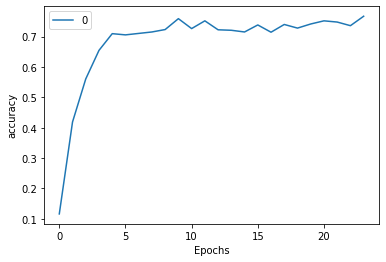

In [15]:
tf.random.set_seed(42)

# Make the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=(20, 20, 3)),
  tf.keras.layers.Dropout(.1),

  tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Dropout(.1),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
  tf.keras.layers.Dropout(.2),

  tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.BatchNormalization(),


  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.04)),
  tf.keras.layers.Dense(62, activation="softmax")
])

# Compile the model
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),
              metrics=["accuracy"])

# Fit the model
history = model.fit(X_train, y_train, epochs=24, validation_data=(X_test, y_test))

# Plotting loss
pd.DataFrame(history.history['val_accuracy']).plot()
plt.xlabel("Epochs")
plt.ylabel("accuracy")

## Getting the output

In [16]:
# Getting Predictions
y_pred = model.predict(final_test_norm)

In [17]:
# Turning predictions into class labels
y_pred_ids = tf.argmax(y_pred,axis=1)
unique_labels = sorted(data_labels['Class'].unique())
y_pred_labels = []
for pred in y_pred_ids:
   y_pred_labels.append(unique_labels[pred])
y_pred = y_pred_labels

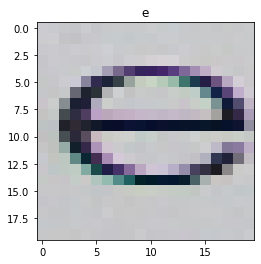

In [18]:
#Visualizing final_test and y_pred
random_index = random.sample(range(0,len(final_test)), 1)
random_index = random_index[0]
plt.imshow(final_test[random_index])
plt.title(y_pred[random_index]);

In [19]:
# Making csv file for submission
df = pd.DataFrame({'ID':ids, 'Class':y_pred})
df.to_csv(r'submission.csv', index = False)